In [ ]:
!ls

In [ ]:
!pwd

In [ ]:
!ls /home/ubuntu/data/tgs

In [ ]:
!pip install pydot

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pydot
import tensorflow as tf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
tf.__version__

'1.10.1'

In [4]:
TRAIN_IMAGE_DIR = 'input/train/images/'
TRAIN_MASK_DIR = 'input/train/masks/'
TEST_IMAGE_DIR = 'input/test/images/'

train_fns = os.listdir(TRAIN_IMAGE_DIR)

In [5]:



X = [np.array(cv2.imread(TRAIN_IMAGE_DIR + p, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for p in tqdm(train_fns)]
X = np.array(X)/255
X = np.expand_dims(X,axis=3)

y = [np.array(cv2.imread(TRAIN_MASK_DIR + p, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for p in tqdm(train_fns)]
y = np.array(y)/255
y = np.expand_dims(y,axis=3)

X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state=23, test_size = 0.2)

from keras.models import Model
from keras.layers import Conv2D, Input, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
def conv_block(num_layers,inp,units,kernel):
    x = inp
    for l in range(num_layers):
        x = Conv2D(units, kernel_size=kernel, padding='SAME',activation='relu')(x)
    return x


inp = Input(shape=(101,101,1))
cnn1 = conv_block(4,inp,32,3)
cnn2 = conv_block(4,inp,24,5)
cnn3 = conv_block(4,inp,16,7)
concat = Concatenate()([cnn1,cnn2,cnn3])
d1 = Conv2D(16,1, activation='relu')(concat)
out = Conv2D(1,1, activation='sigmoid')(d1)

model = Model(inputs = inp, outputs = out)
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy')





100%|██████████| 4000/4000 [00:02<00:00, 1652.76it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 101, 101, 24) 624         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 101, 101, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_layer_names=True, show_shapes=True)

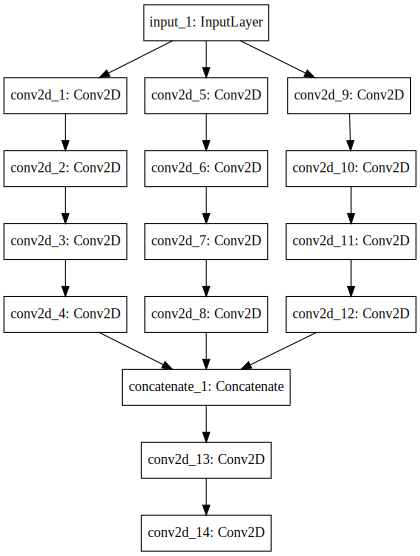

In [7]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [8]:
early_stop = EarlyStopping(patience=5)
check_point = ModelCheckpoint('model.hdf5',save_best_only=True)
model.fit(X_train,y_train, epochs=50, validation_data=(X_valid,y_valid), callbacks=[early_stop,check_point],batch_size=32)


Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 9s 3ms/step - loss: 0.5435 - val_loss: 0.4809
Epoch 2/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.4780 - val_loss: 0.4346
Epoch 3/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.4456 - val_loss: 0.4071
Epoch 4/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.4156 - val_loss: 0.3962
Epoch 5/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.3902 - val_loss: 0.4068
Epoch 6/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.3984 - val_loss: 0.3782
Epoch 7/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.3885 - val_loss: 0.3821
Epoch 8/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.3777 - val_loss: 0.3696
Epoch 9/50
3200/3200 [==============================] - 6s 2ms/step - loss: 0.3672 - val_loss: 0.3810
Epoch 10/50
3200/3200 [============

In [9]:

test_fns = os.listdir(TEST_IMAGE_DIR)
X_test = [np.array(cv2.imread(TEST_IMAGE_DIR + p, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for p in tqdm(test_fns)]
X_test = np.array(X_test)/255
X_test = np.expand_dims(X_test,axis=3)

pred = model.predict(X_test, verbose = True)


def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(pred[i,:,:,0])) for i,fn in tqdm(enumerate(test_fns))}




100%|██████████| 18000/18000 [00:18<00:00, 961.28it/s] 


18000/18000 [==============================] - 11s 608us/step


18000it [04:49, 62.22it/s]


In [12]:
import pandas as pd



sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submissions/kaggle_baseline.csv.gz', compression="gzip")

In [11]:
import kaggle

In [ ]:
kaggle.configuration